In [80]:
import main
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from importlib import reload

In [129]:
reload(main)

<module 'main' from 'c:\\Users\\bdanziger\\Documents\\eurusd-pred\\main.py'>

In [130]:
data = main.load_eurusd_data("histdata_free/", 2023)

In [131]:
features_df = {
        "mean_short": main.get_ewm_macd(data, 3, 15),
        "mean_medium": main.get_ewm_macd(data, 5, 25),
        # "mean_medium2": main.get_ewm_macd(data, 1440, 7200),
        # "mean_long": main.get_ewm_macd(data, 1440, 43200),
        "pinbar": main.get_pinbar(data),
        # "gk_vol": main.get_garman_klass(data),
        "spot": data["Close"]
} | {
    f"previous_return_{i}": data["Close"].pct_change().shift(i) for i in range(1,10)
}
features_df = pd.DataFrame(features_df).dropna()

In [140]:
results_df = main.rolling_regression_forecast(features_df, 60*24)
trade_df = data[["Close"]].join(results_df).dropna()
# trade_df["pos"] = np.nan
# trade_df["pos"] = (trade_df["target"] > 0).astype(int).replace(0, -1)

In [141]:
trade_df

,Close,y_true,y_pred,take_profit,stop_loss,pos
DateTime,,,,,,
2023-01-02 18:01:00,1.06720,0.00036,-0.000150,1.068364,1.066528,1.0
2023-01-02 18:02:00,1.06756,0.00017,-0.000215,1.068364,1.066528,1.0
2023-01-02 18:03:00,1.06773,0.00023,-0.000170,1.068364,1.066528,1.0
2023-01-02 18:04:00,1.06796,0.00011,-0.000240,1.068364,1.066528,1.0
2023-01-02 18:05:00,1.06807,-0.00005,-0.000133,1.068364,1.066528,1.0
...,...,...,...,...,...,...
2023-12-29 16:53:00,1.10387,0.00001,-0.000006,1.103839,1.103825,0.0
2023-12-29 16:54:00,1.10388,0.00007,0.000012,1.103839,1.103825,0.0
2023-12-29 16:55:00,1.10395,-0.00025,-0.000006,1.103839,1.103825,0.0


In [142]:
# for i in range(len(trade_df)):
#     if pd.isna(trade_df.iloc[i,-1]):
#         if trade_df.iloc[i,-2] < trade_df.iloc[i,0] < trade_df.iloc[i,-3]:
#             trade_df.iloc[i,-1] = 1
#         else:
#             index=trade_df[trade_df["take_profit"]==trade_df.iloc[i,-2]].index
#             trade_df.loc[index, "pos"] = 0

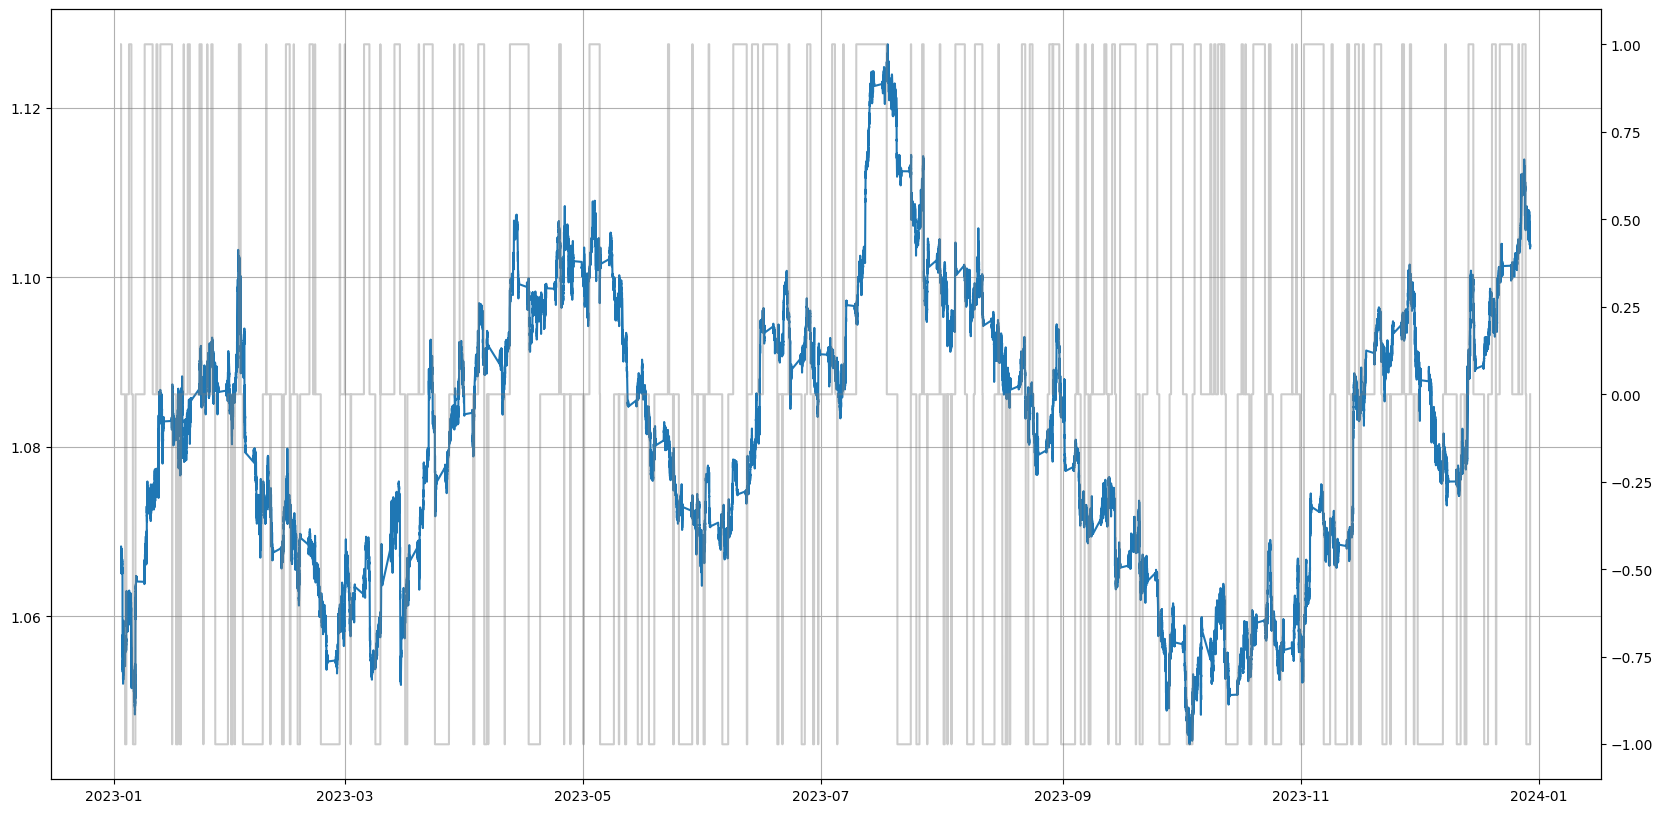

In [143]:
fig, ax  = plt.subplots(figsize = (20,10))
ax.plot(trade_df["Close"])
# ax.plot(trade_df["spot_pred"])
ax1 = ax.twinx()
ax1.plot(trade_df["pos"], color = "grey", alpha = 0.4)
ax.grid()

In [144]:
trade_df["pct_change"] = trade_df["Close"].pct_change()

In [145]:
trade_df["strat_pct"] = trade_df["pct_change"] * trade_df["pos"].shift(1)

In [146]:
trade_df["buy_hold"] = (trade_df["pct_change"]+1).cumprod()
trade_df["strat_cum"] = (trade_df["strat_pct"]+1).cumprod()


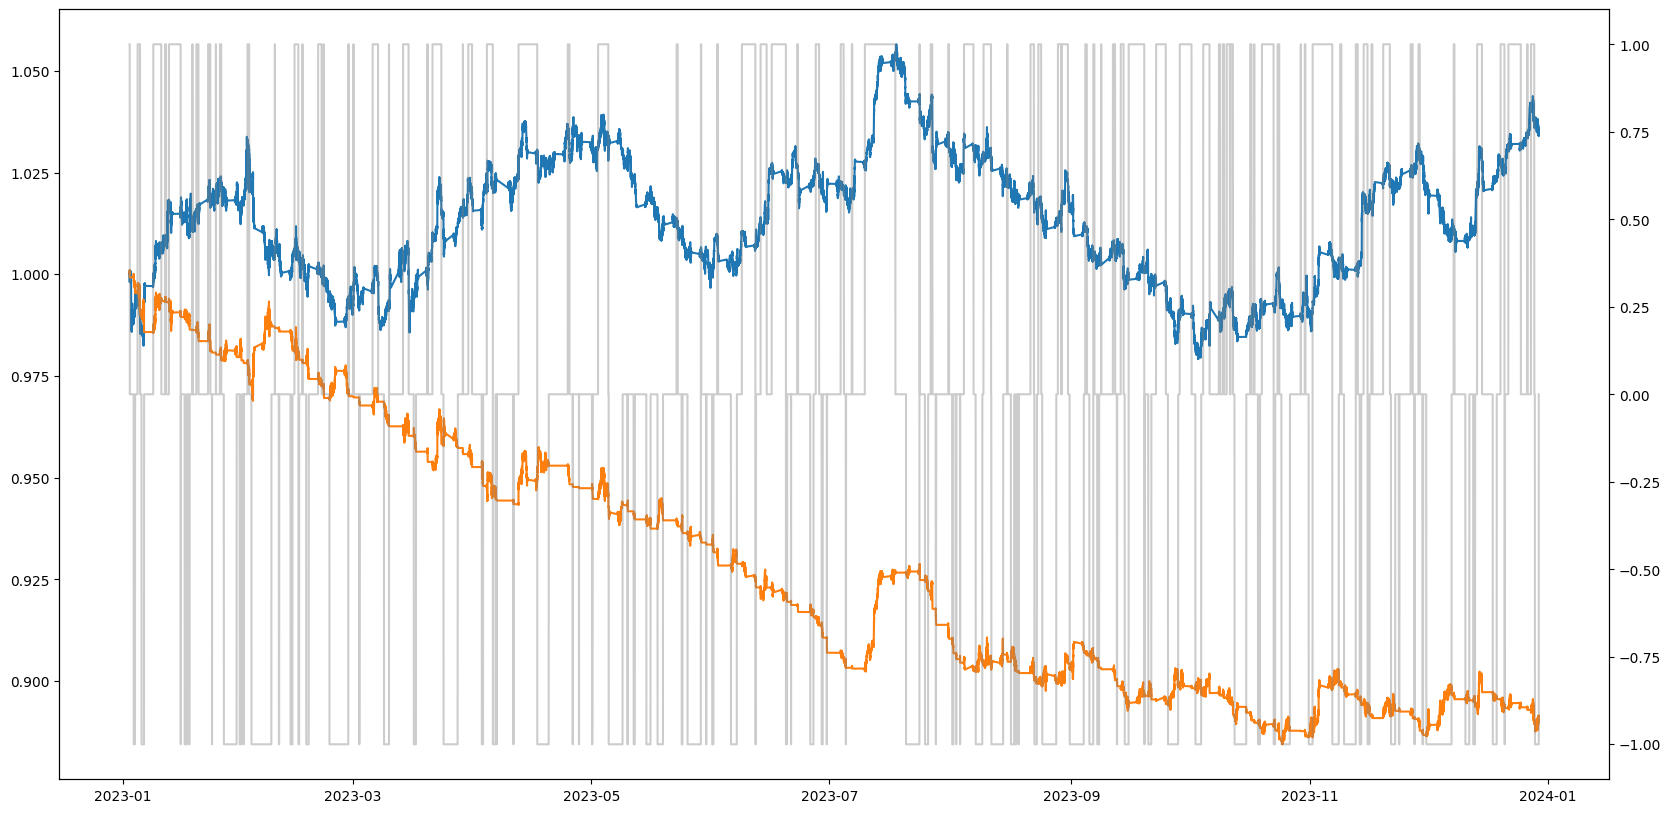

In [147]:
fig, ax  = plt.subplots(figsize = (20,10))
ax.plot(trade_df["buy_hold"])
ax.plot(trade_df["strat_cum"])
ax1 = ax.twinx()
ax1.plot(trade_df["pos"], color = "grey", alpha = 0.4)

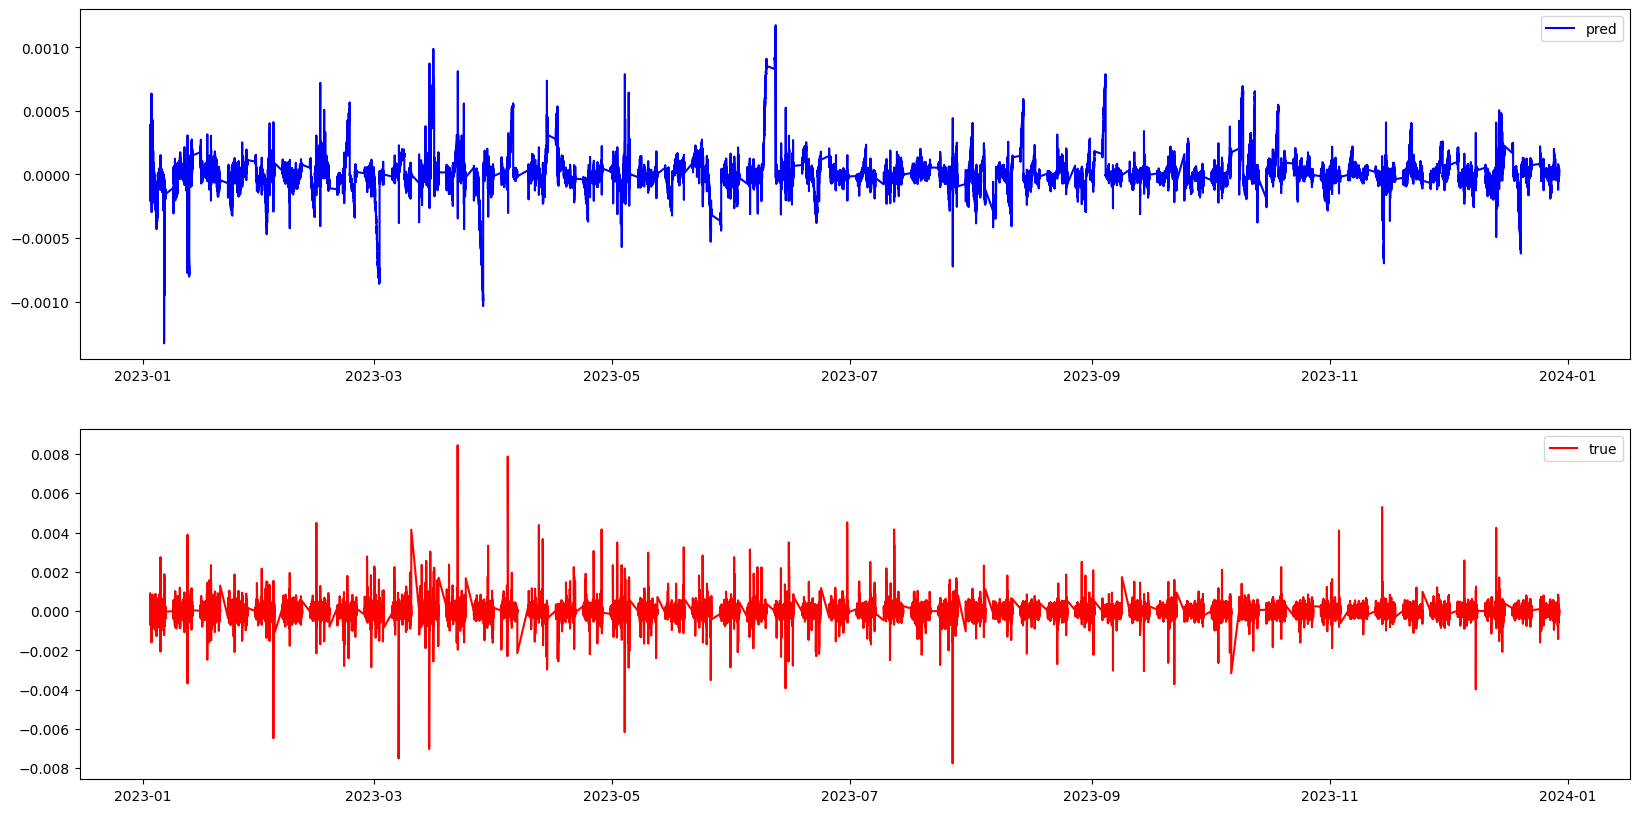

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(20,10))
ax[0].plot(results_df.iloc[:,1], label = "pred", color = "blue")
ax[1].plot(results_df.iloc[:,0], label = "true", color = "red")
ax[0].legend()
ax[1].legend()
